<a href="https://colab.research.google.com/github/ruveydee/NLP-Profissional/blob/main/Pre_Trained_Model_(BERT)_Fine_Tuning_for_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries



In [2]:
!pip install -q datasets

In [3]:
!pip install openpyxl #for read excel files

## Using TPU Cores

In [ ]:
#TPU kullanıyorsak tenserflowun bize sunduğu çekirdekleri tahsis etmek için aşağıdaki kod bloğunu çalıştırmamız gerekiyor.

In [4]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  #TPUClusterResolver, TPU'ların bulunduğu kümeyi (cluster) bulmak için kullanılır.
  print(f'Running on a TPU w/{tpu.num_accelerators()["TPU"]} cores')
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
#Bu kod satırı, TensorFlow'u daha önce oluşturulan tpu nesnesi ile belirtilen TPU kümesine bağlar.
tf.tpu.experimental.initialize_tpu_system(tpu)
#Bu adım, TPU sistemini başlatır ve kullanıma hazır hale getirir.
tpu_strategy = tf.distribute.TPUStrategy(tpu)
#Modeli birden fazla TPU çekirdeğine dağıtarak eğitimi hızlandırır.

Tensorflow version 2.15.0
Running on a TPU w/8 cores


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading Data

In [6]:
import numpy as np
import pandas as pd
#Warning kod bloğunu kullanmak tavsiye edilmiyor. Sürekli güncelleme geldiği için uyarılarda bunları görüyoruz.
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_excel('/content/drive/MyDrive/NLP-Profissionals/trt_11_category.xlsx', engine='openpyxl')
df.head()
df

,Unnamed: 0.1,Unnamed: 0,title,context,category
0,0,0,BTK'nın sosyal ağ sağlayıcılara tanıdığı süre ...,Sosyal medya devlerinin temsilci bildirmesi iç...,bilim_teknoloji
1,1,1,Samsung Yönetim Kurulu Başkanı Lee hayatını ka...,Lee'nin oğlu ve Samsung'un fiili yöneticisi Le...,bilim_teknoloji
2,2,2,Yerli ve milli 5G şebekesi hedefi: Radyolink b...,Uçtan Uca Yerli ve Milli 5G Haberleşme Şebekes...,bilim_teknoloji
3,3,3,Elektrik direğindeki kaçağı haber veren akıllı...,"Enerjisa'dan yapılan açıklamaya göre, söz konu...",bilim_teknoloji
4,4,4,Sosyal medya sitelerinin temsilci bildirmesi i...,"Kamuoyunda ""Sosyal Medya Yasası"" olarak biline...",bilim_teknoloji
...,...,...,...,...,...
35195,3195,3195,Kahramanlığıyla iz bırakan Eren Bülbül'ün şeha...,"Eren Bülbül, Maçkalı Ayşe ve Hasan Bülbül çift...",yasam
35196,3196,3196,Kurban keserken nelere dikkat edilmeli? Kurban...,"Kurban Bayramı, Müslümanlar tarafından Hicri T...",yasam
35197,3197,3197,Sanatsever kardeşlerden Fatsa'da nostaljik fil...,Tiyatro ve sinemaya gönül veren Ali Can ve İlk...,yasam
35198,3198,3198,Yaralı kaplumbağalar rehabilitasyon merkezinde...,"Oltalar, balıkçı ağları, plastik atıklar... De...",yasam


In [8]:
df["context"]= df.title + " " + df.context

In [9]:
#Feature engineering
df=df[["context", "category"]]
df

,context,category
0,BTK'nın sosyal ağ sağlayıcılara tanıdığı süre ...,bilim_teknoloji
1,Samsung Yönetim Kurulu Başkanı Lee hayatını ka...,bilim_teknoloji
2,Yerli ve milli 5G şebekesi hedefi: Radyolink b...,bilim_teknoloji
3,Elektrik direğindeki kaçağı haber veren akıllı...,bilim_teknoloji
4,Sosyal medya sitelerinin temsilci bildirmesi i...,bilim_teknoloji
...,...,...
35195,Kahramanlığıyla iz bırakan Eren Bülbül'ün şeha...,yasam
35196,Kurban keserken nelere dikkat edilmeli? Kurban...,yasam
35197,Sanatsever kardeşlerden Fatsa'da nostaljik fil...,yasam
35198,Yaralı kaplumbağalar rehabilitasyon merkezinde...,yasam


In [10]:
df.category.value_counts()

,count
category,
bilim_teknoloji,3200
dunya,3200
egitim,3200
ekonomi,3200
guncel,3200
gundem,3200
kultur_sanat,3200
saglik,3200
spor,3200


In [11]:
unique_labels = df.category.unique()
unique_labels

array(['bilim_teknoloji', 'dunya', 'egitim', 'ekonomi', 'guncel',
       'gundem', 'kultur_sanat', 'saglik', 'spor', 'turkiye', 'yasam'],
      dtype=object)

In [12]:
#!Model targetları numeric olarak istiyor. Bu yüzden bir dict oluşturuyoruz.
label_dict = {j:i for i, j in enumerate(unique_labels)}
label_dict

{'bilim_teknoloji': 0,
 'dunya': 1,
 'egitim': 2,
 'ekonomi': 3,
 'guncel': 4,
 'gundem': 5,
 'kultur_sanat': 6,
 'saglik': 7,
 'spor': 8,
 'turkiye': 9,
 'yasam': 10}

In [13]:
df.category = df.category.map(label_dict)

In [14]:
#Arraylere dönüştürüyorum çünkü DL modelleri arrayler üzerinde daha hızlı çalışıyor.
X = df['context'].values
y = df['category'].values

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Max Text Length

## [Pre-trained model Classification](https://huggingface.co/docs/transformers/tasks/sequence_classification)

In [16]:
# For every sentence... "https://huggingface.co/dbmdz/bert-base-turkish-uncased"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

number_tokens_sentences = []
for sent in X_train:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.

    input_ids = tokenizer.encode(str(sent),
                                 add_special_tokens=True #başına ve sonuna özel token gelecek [SEP],[CLS]
                                )

    number_tokens_sentences.append(len(input_ids))

print('Max sentence length: ', max(number_tokens_sentences))

#Bert modeli 512 tokenden fazla token alamıyor. Fazla tokenler kırpılıyor az ise belirlediğimiz veya max token sayısına sayıya sabitliyoruz.
#Bert modeldeher text aynı boyutta olmalıdır.
# tokenizer.encode() fonksiyonunu sadece en uzun yorumun kaç tokenden oluştuğu bulmak ve tüm textleri kaç tokene sabitliyeceğimize karar vermek için kullanacağız.

Token indices sequence length is longer than the specified maximum sequence length for this model (1410 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  7769


In [17]:
#for instance;
sentence=" how are you ?"

tokenizer.encode(str(sentence),
                 add_special_tokens=True)

[2, 25223, 17379, 9751, 35, 3]

In [18]:
len(tokenizer.encode(str(sentence),add_special_tokens=True))

6

In [19]:
tokenizer.decode([2, 25223, 17379, 9751, 35, 3])

'[CLS] how are you? [SEP]'

In [20]:
#Example
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) <= 11)
print(sum(np.array(list) <= 11))
print(sum(np.array(list) <= 11)/len(list))

# Örnek: Corpusumuzda 6 adet yorum olduğunu varsayalım. ilk yorum 5, ikinci yorum 10, üçüncü yorum 8, dördüncü yorum 9, beşinci
# yorum 12 ve altıncı yorum 15 tokenden oluşuyor.

# Tüm yorumları 11 tokene sabitlersem kaç yorumda bilgi/token kaybı olmayacağına bakalım.

# ilk 4 yorumda herhangi bir bilgi/token kaybı olmayacak, ancak 5. yorumda 1 token, 6. yorumda 4 token kaybı olacak.
# np.array(list) <= 11 kodu ile tüm yorumları 11 tokene sabitlediğimizde bilgi/token kaybı olmayan yorumların True olarak,
# bilgi/token kaybı olanların False olarak döndürülmesini sağlıyorum --> [ True  True  True  True False False]
# sum(np.array(list) <= 11) kodu ile öncelikle Truelar 1'e, Falselar 0'a dönüştürülür. Sonra da bu değerler toplanır. Çıkan
# sonuç kaç yorumda bilgi/token kaybı olmadığını bize gösterir.
# [True  True  True  True False False]-->[1 1 1 1 0 0]--> sum([1 1 1 1 0 0])-->4 --> cospusumdaki 6 yorumun 4'ünde bilgi/token
# kaybı yok.
# Elde ettiğimiz 4 sonucunu corpsumuzdaki tüm yorumların sayısına (len([5, 10, 8, 9, 12, 15])-->6) böldüğümüzde bize oran
# olarak kaç yorumda bilgi/token kaybı olmadığını döndürür (4/6 --> 0.67).

#Biz bu oranın %95 ve üzeri olmasını istiyoruz.
#Eğer küçük olsaydı 512 den illa 512 ye sabitlememiz gerekmiyor. Herseferinde 512 ye sabitlemek maliyeti arttırabilr. %90-95 oranına

[ True  True  True  True False False]
4
0.6666666666666666


In [21]:
print(sum(np.array(list) > 11)/len(list)) #örnekte %33 token kaybı olmuş

0.3333333333333333


In [22]:
sum(np.array(number_tokens_sentences) <= 512) / len(number_tokens_sentences)
#kendi datamıza uygulayınca %70 kayıp olmuyor.%30 kırpılma olcak.

0.7025213068181818

## Converting Data to Dataset Format

In [ ]:
#[{'text': 'değişken', 'label': 0}]

In [23]:
train_text=[]
for i, j in zip(X_train, y_train): # zip fonksiyonu
  train_text.append({"text": str(i), "label":j})

test_text=[]
for i, j in zip(X_test, y_test):
  test_text.append({"text": str(i), "label":j})

In [24]:
train_text[0:2]

[{'text': "Artistik buz pateni yarışmalarına koronavirüs engeli Türkiye Buz Pateni Federasyonundan yapılan açıklamada, ISU Konsey Toplantısı'nın ardından alınan kararlar doğrultusunda, Junior Grand Prix yarışmalarının sürdürülemeyeceği ve serinin tüm etkinliklerinin iptal edildiği ifade edildi. İptal kararının, sağlık komisyonunun önerileri ile etkinlik katılımcılarının güvenliği ve sağlığının gözetilerek alındığı belirtildi. Yeni sezon planlamasının ve diğer etkinliklerin ise 3 Ağustos'ta çevrim içi düzenlenecek toplantıda tekrar değerlendirileceği aktarıldı.",
  'label': 8},
 {'text': 'ASELSAN "en çekici işveren" seçildi ASELSAN\'dan yapılan açıklamaya göre, Universum 2018 Türkiye’nin Öğrenci ve Çalışan Y Kuşağı İçin En Çekici İşverenler Araştırması sonuçları açıklandı. Universum tarafından 61 ülkede 1,8 milyon genç ile yapılan En Çekici İşveren Araştırması\'nın Türkiye ayağı, 6. yılında 46 üniversiteden 41 bin 117 öğrenci ve ortalama 3 yıldır iş hayatında olan 13 bin 116 genç profes

In [25]:
#Modelin istediğ format dataset formatı olduğu için dönüştürüyoruz.
from datasets import Dataset
train_dataset = Dataset.from_list(train_text)
test_dataset = Dataset.from_list(test_text)

In [26]:
train_dataset[:2]

{'text': ["Artistik buz pateni yarışmalarına koronavirüs engeli Türkiye Buz Pateni Federasyonundan yapılan açıklamada, ISU Konsey Toplantısı'nın ardından alınan kararlar doğrultusunda, Junior Grand Prix yarışmalarının sürdürülemeyeceği ve serinin tüm etkinliklerinin iptal edildiği ifade edildi. İptal kararının, sağlık komisyonunun önerileri ile etkinlik katılımcılarının güvenliği ve sağlığının gözetilerek alındığı belirtildi. Yeni sezon planlamasının ve diğer etkinliklerin ise 3 Ağustos'ta çevrim içi düzenlenecek toplantıda tekrar değerlendirileceği aktarıldı.",
  'ASELSAN "en çekici işveren" seçildi ASELSAN\'dan yapılan açıklamaya göre, Universum 2018 Türkiye’nin Öğrenci ve Çalışan Y Kuşağı İçin En Çekici İşverenler Araştırması sonuçları açıklandı. Universum tarafından 61 ülkede 1,8 milyon genç ile yapılan En Çekici İşveren Araştırması\'nın Türkiye ayağı, 6. yılında 46 üniversiteden 41 bin 117 öğrenci ve ortalama 3 yıldır iş hayatında olan 13 bin 116 genç profesyonelden edinilen bilgi

In [27]:
train_dataset #And we have texts and labels.

Dataset({
    features: ['text', 'label'],
    num_rows: 28160
})

## Tokenization

In [28]:
#for instance;

sentence=" How are you ? "

tokenized_data = tokenizer(  text=sentence,
                             return_tensors="np", #np dönüştür datayı hazırlama kısmı olduğu için np oldu, ilerde TF dönüştürecceğiz.
                             padding="max_length", #dolgulama işlemi
                             truncation=True, #kırpma işlemi
                             max_length=8, #max token sayısı
                             add_special_tokens=True #[CLS],[SEP]
                          )
tokenized_data
#3 vektörü(tensör) olmazsa hata verir.
#Pre-trained modellere bir text verirken tek bir vektör şeklinde değil 3 vektör ile istiyor.

{'input_ids': array([[    2, 25223, 17379,  9751,    35,     3,     0,     0]]), 'token_type_ids': array([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1, 0, 0]])}

In [29]:
from transformers import AutoTokenizer
import numpy as np

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")
def transformation(examples):
  seq=512 #max token sayısı
  tokenized_data = tokenizer(text=examples["text"],
                             return_tensors="np", #np dönüştür
                             padding="max_length",
                             truncation=True,
                             max_length=seq, #512
                             add_special_tokens=True)
  return tokenized_data

train_tokenized_data = train_dataset.map(transformation, batched=True) #batched dönüşüm işlemlerini çok daha hızlandırıyor
test_tokenized_data = test_dataset.map(transformation, batched=True)

Map:   0%|          | 0/28160 [00:00<?, ? examples/s]

Map:   0%|          | 0/7040 [00:00<?, ? examples/s]

In [30]:
train_tokenized_data #3 vektörle birlikte geldi
#Pre-trained modellere bir text verirken tek bir vektör şeklinde değil 3 vektör ile istiyor.

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 28160
})

In [31]:
test_tokenized_data #3 vektörle birlikte geldi

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7040
})

In [32]:
train_tokenized_data["input_ids"][:1] #512 e sabitleyecek şekilde doldurdu

[[2,
  2488,
  4866,
  5794,
  3339,
  2194,
  5093,
  10542,
  5112,
  2106,
  27927,
  8423,
  1977,
  2132,
  25237,
  23216,
  5794,
  3339,
  2194,
  7789,
  17784,
  2697,
  20562,
  2177,
  1986,
  16,
  2578,
  1013,
  13843,
  7134,
  11,
  2757,
  3146,
  4365,
  10487,
  18029,
  1012,
  3073,
  14343,
  16,
  18011,
  9078,
  1024,
  14400,
  14683,
  1076,
  5093,
  10542,
  5112,
  2196,
  3304,
  2553,
  17634,
  2663,
  2098,
  2287,
  1992,
  20051,
  21155,
  27814,
  1973,
  6021,
  4396,
  2287,
  3069,
  4396,
  18,
  6021,
  12377,
  16,
  9752,
  2090,
  30946,
  12496,
  2819,
  2068,
  2081,
  4539,
  17642,
  1976,
  6856,
  2521,
  16282,
  1992,
  9752,
  1991,
  22565,
  1014,
  21540,
  3025,
  18840,
  6475,
  2958,
  6797,
  18,
  2312,
  3791,
  22138,
  10779,
  1992,
  17319,
  27814,
  2365,
  23,
  7996,
  3566,
  2249,
  11,
  2108,
  3231,
  5865,
  4470,
  1023,
  27010,
  1975,
  15931,
  8238,
  3347,
  19912,
  2654,
  2616,
  2098,
  2287,
  

## Create Optimizer and Training with TPU Cores

In [33]:
print(len(train_tokenized_data["input_ids"])//32) #Tavsiye edilen batch_size 16(2^4),32(2^5) ne kadar küçükse o kadar iyi öğrenir.
print(len(train_tokenized_data["input_ids"])//16)
#Modele 1 epochda(bir eğitimde)  kaç defa 32li paketler halinde vereceksin
#Modele 880 defa 32 li paketleri besleyecek

880
1760


In [67]:
from transformers import create_optimizer #kendi optimezerımzıı kendimiz oluşturcaz

batch_size = 32 #32, 16 kaçarlı paketler halinde vereceğiz
num_train_epochs = 2 # 3, 4 modele besleme
num_train_steps = (len(train_tokenized_data["input_ids"]) // batch_size) * num_train_epochs #eğitim boyunca atacağımız adım sayısı 880*2epoch = 1760
optimizer, lr_schedule = create_optimizer(
                                          init_lr = 2e-5, #3e-5, 5e-5 learning_rate
                                          num_train_steps= num_train_steps,
                                          weight_decay_rate= 0.01, # Ağırlık küçülme oranı bu sayede over fite gitmeyi azaltıyoruz.
                                          num_warmup_steps= 0.1) ## Isınma adımları sayısı
                                          #num_warmup_steps= num_train_steps * 0.1 ilk %10luk kesimde bu şekilde overfite gitme düşük


In [68]:
optimizer

In [69]:
lr_schedule.get_config()

{'initial_learning_rate': 2e-05,
 'decay_schedule_fn': <tf_keras.src.optimizers.schedules.learning_rate_schedule.PolynomialDecay at 0x7c450ae8fa30>,
 'warmup_steps': 0.1,
 'power': 1.0,
 'name': None}

In [70]:
optimizer.get_config()

{'name': 'AdamWeightDecay',
 'learning_rate': {'module': 'transformers.optimization_tf',
  'class_name': 'WarmUp',
  'config': {'initial_learning_rate': 2e-05,
   'decay_schedule_fn': {'module': 'keras.optimizers.schedules',
    'class_name': 'PolynomialDecay',
    'config': {'initial_learning_rate': 2e-05,
     'decay_steps': 1759.9,
     'end_learning_rate': 0.0,
     'power': 1.0,
     'cycle': False,
     'name': None},
    'registered_name': None},
   'warmup_steps': 0.1,
   'power': 1.0,
   'name': None},
  'registered_name': 'WarmUp'},
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-08,
 'amsgrad': False,
 'weight_decay_rate': 0.01}

In [71]:
#sadece TPU da kullanıyorsak bu koda bloğunu çalıştır
with tpu_strategy.scope():

    from transformers import TFAutoModelForSequenceClassification

    #from tensorflow.keras.optimizers import AdamW
    #from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy

    # Load and compile our model
    model = TFAutoModelForSequenceClassification.from_pretrained("dbmdz/bert-base-turkish-uncased",
                                                                 num_labels=11)
    # loss= SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.ReductionV2.NONE)


    model.compile(optimizer=optimizer, metrics=["accuracy"])  # No loss argument!

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
#TPU sadece tensorflowda çalıştığı için datasetini tensorflow tensorlerine dönüştürüyor.(prepare_tf_dataset)
tf_dataset_train = model.prepare_tf_dataset(train_tokenized_data, batch_size=32, shuffle=False) #yukarda bahtch size ne ise burda da o olmalı
tf_dataset_test = model.prepare_tf_dataset(test_tokenized_data, batch_size=32, shuffle=False) #shuffle yapınca skorları alması zorlaşıyor.

In [73]:
tf_dataset_train #TensorFlow tensorlerine dönüştürmüş, None yerine 32 yazmalı ama 32 tam bölünmediği için None yazıyor.
#En sonda label id yazmamış zaten blyor

<_PrefetchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [74]:
model.fit(tf_dataset_train,
          validation_data=(tf_dataset_test),
          epochs=num_train_epochs)

#sürümden dolayı hata veriyor. Kütüphaneler arasındaki uyumu bozmamak için güncellemiyoruz

Epoch 1/2
880/880 [==============================] - 286s 206ms/step - loss: 0.7399 - accuracy: 0.7668 - val_loss: 0.5072 - val_accuracy: 0.8287
Epoch 2/2
880/880 [==============================] - 164s 186ms/step - loss: 0.4133 - accuracy: 0.8656 - val_loss: 0.4742 - val_accuracy: 0.8435


In [ ]:
#epoch sayısı ilerlediği zaman ilk değerler gerçeği yansıtmaya başlıyor. Modeli ne kadar beslersek o kadar iyi öğrenir.
#Overfitting olmamasına dikkat etmek gerekiyor !

In [75]:
model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  8459      
                                                                 
Total params: 110625803 (422.00 MB)
Trainable params: 110625803 (422.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluation

In [76]:
model_loss = pd.DataFrame(model.history.history)
model_loss.head()

,loss,accuracy,val_loss,val_accuracy
0,0.739859,0.766797,0.507217,0.828693
1,0.413323,0.865625,0.474160,0.843466


<Axes: >

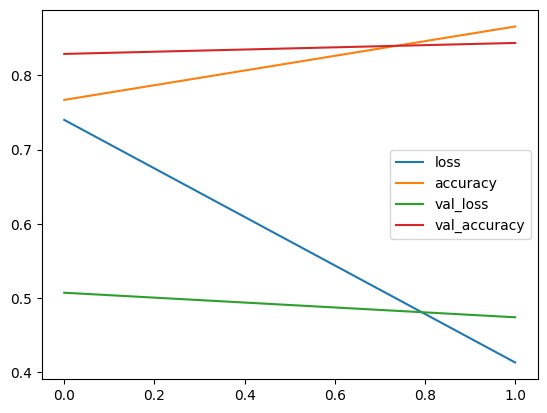

In [77]:
model_loss.plot()

"Logits" terimi, derin öğrenme modelleri ve sinir ağlarında sıkça kullanılan bir terimdir. Logits, modelin son katmanından çıkan, genellikle bir doğrusal dönüşüm ve bir aktivasyon fonksiyonundan önceki ham puanları ifade eder.

Bir sınıflandırma probleminde, logits çıktıları genellikle aşağıdaki gibi yorumlanır:

- **Çok sınıflı sınıflandırma**: Modelin farklı sınıflar için hesapladığı ham puanlar. Bu puanlar, genellikle softmax fonksiyonu uygulanarak olasılıklara dönüştürülür.
- **İkili sınıflandırma**: İki sınıf arasındaki karar sınırını belirlemek için kullanılan ham puanlar. Bu puanlar, sigmoid fonksiyonu ile olasılıklara dönüştürülür.

Logits değerlerini anlamak için şu adımları izleyebilirsiniz:
1. **Softmax Uygulama**: Logits değerlerini olasılıklara dönüştürmek için softmax fonksiyonunu kullanabilirsiniz. Bu, her sınıf için olasılıkların toplamının 1 olmasını sağlar.
2. **Tahmin**: En yüksek olasılığa sahip sınıf, modelin tahmini olarak seçilir.

In [78]:
logits= model.predict(tf_dataset_test)
logits

220/220 [==============================] - 28s 53ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 1.809303  , -1.3702545 , -1.0316867 , ..., -1.8097322 ,
        -0.19451556, -1.1625067 ],
       [-2.119552  , -2.457046  , -0.78798264, ..., -1.1254185 ,
         4.65564   , -0.27660283],
       [-2.1878183 , -1.515945  , -1.7320825 , ..., -1.1634564 ,
         5.486226  ,  0.70159537],
       ...,
       [ 2.8476357 , -1.2693425 , -1.5469625 , ..., -1.6706407 ,
        -0.04113184, -1.6759777 ],
       [-0.30672416,  0.21066579, -0.7717872 , ...,  6.951844  ,
        -0.9557444 , -0.45561403],
       [ 4.7467346 , -0.38428953,  1.0579066 , ..., -1.63537   ,
        -2.1061788 ,  1.8573753 ]], dtype=float32), hidden_states=None, attentions=None)

In [79]:
logits.logits

array([[ 1.809303  , -1.3702545 , -1.0316867 , ..., -1.8097322 ,
        -0.19451556, -1.1625067 ],
       [-2.119552  , -2.457046  , -0.78798264, ..., -1.1254185 ,
         4.65564   , -0.27660283],
       [-2.1878183 , -1.515945  , -1.7320825 , ..., -1.1634564 ,
         5.486226  ,  0.70159537],
       ...,
       [ 2.8476357 , -1.2693425 , -1.5469625 , ..., -1.6706407 ,
        -0.04113184, -1.6759777 ],
       [-0.30672416,  0.21066579, -0.7717872 , ...,  6.951844  ,
        -0.9557444 , -0.45561403],
       [ 4.7467346 , -0.38428953,  1.0579066 , ..., -1.63537   ,
        -2.1061788 ,  1.8573753 ]], dtype=float32)

In [80]:
logits.logits[0]

array([ 1.809303  , -1.3702545 , -1.0316867 ,  4.582952  , -0.9497315 ,
        1.7878413 , -1.5044726 , -0.69060075, -1.8097322 , -0.19451556,
       -1.1625067 ], dtype=float32)

In [81]:
import tensorflow as tf

probabilities = tf.nn.softmax(logits.logits, axis=-1).numpy()

probabilities

array([[5.4082189e-02, 2.2500388e-03, 3.1566620e-03, ..., 1.4498644e-03,
        7.2913314e-03, 2.7695792e-03],
       [7.7862083e-04, 5.5558985e-04, 2.9486241e-03, ..., 2.1041308e-03,
        6.8195331e-01, 4.9170973e-03],
       [4.2757328e-04, 8.3714671e-04, 6.7442597e-04, ..., 1.1909276e-03,
        9.2003804e-01, 7.6889503e-03],
       ...,
       [2.9316112e-01, 4.7766725e-03, 3.6187326e-03, ..., 3.1977443e-03,
        1.6312879e-02, 3.1807241e-03],
       [6.9994718e-04, 1.1742614e-03, 4.3963364e-04, ..., 9.9408013e-01,
        3.6576265e-04, 6.0311920e-04],
       [8.9026189e-01, 5.2618952e-03, 2.2257693e-02, ..., 1.5059303e-03,
        9.4044913e-04, 4.9509086e-02]], dtype=float32)

In [82]:
y_pred=np.argmax(probabilities, axis=1)
y_pred

array([3, 9, 9, ..., 3, 8, 0])

In [83]:
def classification(tokenized_data):
  import tensorflow as tf
  import numpy as np

  logits= model.predict(tokenized_data)
  probabilities = tf.nn.softmax(logits.logits, axis=-1).numpy()
  y_pred = np.argmax(probabilities, axis=1)
  return y_pred

In [84]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred=classification(tf_dataset_test)
print(classification_report(y_test, y_pred, target_names=unique_labels))

220/220 [==============================] - 14s 53ms/step
                 precision    recall  f1-score   support

bilim_teknoloji       0.84      0.92      0.88       640
          dunya       0.92      0.88      0.90       640
         egitim       0.90      0.95      0.93       640
        ekonomi       0.83      0.88      0.85       640
         guncel       0.79      0.80      0.79       640
         gundem       0.83      0.74      0.78       640
   kultur_sanat       0.81      0.90      0.85       640
         saglik       0.84      0.88      0.86       640
           spor       0.98      0.97      0.98       640
        turkiye       0.75      0.68      0.71       640
          yasam       0.77      0.69      0.72       640

       accuracy                           0.84      7040
      macro avg       0.84      0.84      0.84      7040
   weighted avg       0.84      0.84      0.84      7040



In [85]:
y_train_pred=classification(tf_dataset_train)
print(classification_report(y_train, y_train_pred, target_names=unique_labels))

880/880 [==============================] - 48s 53ms/step
                 precision    recall  f1-score   support

bilim_teknoloji       0.89      0.95      0.92      2560
          dunya       0.96      0.91      0.93      2560
         egitim       0.91      0.97      0.94      2560
        ekonomi       0.88      0.92      0.90      2560
         guncel       0.86      0.85      0.85      2560
         gundem       0.87      0.80      0.83      2560
   kultur_sanat       0.85      0.94      0.90      2560
         saglik       0.89      0.93      0.91      2560
           spor       0.99      0.99      0.99      2560
        turkiye       0.85      0.76      0.80      2560
          yasam       0.84      0.77      0.80      2560

       accuracy                           0.89     28160
      macro avg       0.89      0.89      0.89     28160
   weighted avg       0.89      0.89      0.89     28160



## Saving and Loading The Model

In [89]:
model.save_pretrained("/content/drive/MyDrive/NLP-Profissionals/saved_model")

In [87]:
#model.save_pretrained("./saved_model") colabın geçici hafızasına kaydetmek için.

In [90]:
#eğer TPU altında çalışıp skorları aldıysak tekrar TPU altında load etmeliyiz.
with tpu_strategy.scope(): #modeli geri yüklemek için
  loaded_model = TFAutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/NLP-Profissionals/saved_model")

Some layers from the model checkpoint at /content/drive/MyDrive/NLP-Profissionals/saved_model were not used when initializing TFBertForSequenceClassification: ['dropout_113']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/drive/MyDrive/NLP-Profissionals/saved_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


## Prediction

In [91]:
sample1="Meteorolojiden kuvvetli yağış uyarısı Meteoroloji Genel Müdürlüğünden yapılan uyarıya göre, yarın Kıyı Ege \
(İzmir, Aydın, Muğla, Manisa) ile Edirne'nin güneyi, Balıkesir'in batı kıyıları (Edremit, Ayvalık, Burhaniye, Havran, \
Gömeç ilçeleri) ve Çanakkale çevrelerinde kuvvetli ve yer yer çok kuvvetli, gök gürültülü sağanak öngörülüyor. Ani sel, \
su baskını, yıldırım, yağış anında kuvvetli rüzgar, yerel dolu yağışı ve hortum gibi olumsuzluklara karşı dikkatli ve \
tedbirli olunması gerekiyor."

In [92]:
sample2="""Teknopark İstanbul'un Rejenerasyon-20 projesine başvurular başladı Teknopark İstanbul açıklamasına göre, evde yaşam,\
 erişim-lojistik, uzaktan çalışma ve sosyal girişim konularında çalışmalar yapan ön kuluçka ve kuluçka aşamasına gelen \
 girişimcilerin başvurabileceği Rejenerasyon-20 projesi girişim ekosisteminin yeniden yapılanmasını kapsıyor. Projeyle; \
 prototip üretme, prototip geliştirme veya ürünleşme aşamasındaki girişimlere dijital hızlandırma, ticarileşme aşamasındaki \
 girişimlere ise danışmanlık programı verilecek. Danışmanlık programından; ürününü bitirmiş, "scale up" aşamasında olan ya da \
 salgından önce gelir üretebilen fakat şu an iş yapmakta zorlanan genç girişimler yararlanabilecek. Başvuruların 3-17 Temmuz'da \
 gerçekleştirilebileceği Rejenerasyon-20 Projesi'ne, rejenerasyon20.com adresinden başvurulabiliyor. Dijital Hızlandırma Programı'na\
  başlayacak olan 15 girişim grubu; proje ekibi, teknik destek yetkilisi ve insan kaynakları danışmanının ortak görüşü ile \
  değerlendirmeye alınacak. 150 saat mentorluk desteği verilecek Program boyunca girişim gruplarına toplamda; 50 saat finansal \
  danışmanlık desteği, 360 saat teknik analiz, yazılım danışmanlığı ve test desteği, 150 saat mentorluk desteği, 150 saat insan \
  kaynakları danışmanlığı, 30 saat hukuk danışmanlık desteği, 30 saat fikri ve sınai mülkiyet haklar danışmanlık desteği, \
  stratejik marka iletişimi ve dijital pazarlama danışmanlığı, iş geliştirme ve pazarlama desteği, prototipleme-üretim \
  danışmanlığı, kapsamlı stratejik analiz ve plan oluşturma desteği, 6 ay boyunca iş geliştirme uygulamaları desteği \
  gibi destekler sunulacak. Ara değerlendirme sonrasında elemeden geçecek 15 girişimci sayısı jüri elemesi sonucu 10'a \
  düşürülecek. İkinci aşamaya geçen 10 girişime ayrıca; sosyal medya tanıtım desteği, kurumsal kimlik ve dijital tasarım \
  desteği, 100 saat kullanıcı ara yüz tasarım desteği, prototipleme desteği, 2 yıl boyunca bulut veri depolama hizmeti \
  sunulacak. Program sonunda 10 girişim, "demoday" etkinliğinde kurumsal firma ve yatırımcılara sunum yapma fırsatına \
  erişecek. Danışmanlık başvurusundan ise 25 girişim yararlanabilecek. Bu girişimlere toplamda 300 saatlik psikolojik, \
  finansal ve pazarlama danışmanlığı verilecek. Öte yandan, projenin son ayağı olan Video Portal Modülü ile daha büyük \
  kitleye hitap edilecek ve girişimlerin en çok merak ettiği 100 soru konunun uzmanları tarafından kısa videolarla cevaplanacak. \
  "Uluslararası arenada rekabet eden ürünlerin hayata geçeceğine inanıyoruz" Açıklamada görüşlerine yer verilen Teknopark İstanbul \
  Genel Müdürü Bilal Topçu, destekten yararlanacak girişimcilerin; kalıcı, uygulanabilir ve çağdaş metotlara dayanan destek \
  mekanizmalarıyla projelerini başarıyla hayata geçireceklerini belirterek, şunları kaydetti: "Rejenerasyon-20 ile \
  girişimcilik ekosistemimizdeki başarılı genç beyinlerimizin uluslararası arenada rekabet eden ürünler ve uygulamalar hayata \
  geçireceğine inanıyoruz."""

In [93]:
samples=[]
for i in [sample1, sample2]:
  samples.append({"text": str(i)})

In [94]:
def prep_data(samples, model):
  from datasets import Dataset
  samples_dataset = Dataset.from_list(samples)
  samples_tokenized_data = samples_dataset.map(transformation, batched=True)
  tf_dataset_samples = model.prepare_tf_dataset(samples_tokenized_data , batch_size=32, shuffle=False)
  return tf_dataset_samples

In [96]:
tf_dataset_samples=prep_data(samples, loaded_model) #loed ettiğim model

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [97]:
logits=loaded_model.predict(tf_dataset_samples)
logits

1/1 [==============================] - 18s 18s/step


TFSequenceClassifierOutput(loss=None, logits=array([[-2.119552  , -2.457046  , -0.78798264, -1.4512428 ,  3.7963486 ,
         0.49406558, -1.4886853 , -0.3986424 , -1.1254185 ,  4.65564   ,
        -0.27660283],
       [ 4.335328  , -0.2562752 , -0.73242676,  2.1521454 ,  0.6746093 ,
         0.427798  , -1.6206292 , -1.3415682 , -1.5459846 , -0.93438447,
        -1.4321568 ]], dtype=float32), hidden_states=None, attentions=None)

In [98]:
probs= tf.nn.softmax(logits.logits, axis=-1).numpy()
probs

array([[7.7862083e-04, 5.5558985e-04, 2.9486241e-03, 1.5190395e-03,
        2.8878129e-01, 1.0626882e-02, 1.4632148e-03, 4.3521873e-03,
        2.1041308e-03, 6.8195331e-01, 4.9170973e-03],
       [8.3892757e-01, 8.5038682e-03, 5.2823424e-03, 9.4532311e-02,
        2.1572201e-02, 1.6854106e-02, 2.1731267e-03, 2.8726307e-03,
        2.3415464e-03, 4.3163574e-03, 2.6238423e-03]], dtype=float32)

In [99]:
y_pred = np.argmax(probs, axis=1)
y_pred

array([9, 0])

In [100]:
label_dict

{'bilim_teknoloji': 0,
 'dunya': 1,
 'egitim': 2,
 'ekonomi': 3,
 'guncel': 4,
 'gundem': 5,
 'kultur_sanat': 6,
 'saglik': 7,
 'spor': 8,
 'turkiye': 9,
 'yasam': 10}

In [101]:
classification(tf_dataset_samples)

1/1 [==============================] - 16s 16s/step


array([9, 0])

# Thank you for your visit ❤

##The End ♟